In [1]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# from nn_train import do_job
import random

# cna not import into global namespace  for multiprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, TimeDistributed, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from multiprocessing import Process, Pool

import os
import multiprocessing as mp
import warnings
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
EARLIEST_DATE = '2012-01-01'
N_COMPONENTS=100

# REad in data

In [3]:

def read_in_data(check_recent_date=True, recent_date_check=datetime.datetime.now().date()):
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_and_etf_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        df_  = pd.read_csv(f"{file_}")
#         try:
#             df_.index = df_.date
#             df_.drop('date', inplace=True)
#         except ValueError:
#             pass
        # ensure we have the most recent data
        try:
            most_recent_date = pd.to_datetime(df_.date.max())
            oldest_date = pd.to_datetime(df_.date.min())
        except Exception:
            continue
        
        oldest_date_bool = oldest_date < datetime.datetime(2018,1,1).date()
        recent_date_bool = most_recent_date == recent_date_check
        
        if oldest_date_bool and recent_date_bool:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')
        elif oldest_date_bool and not check_recent_date:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')            
        else:
            print(f"Stock {stock_name} most recent date is {most_recent_date} oldest date is {oldest_date}. Skipping it")
    return dict_of_stocks_and_dfs

In [4]:
dict_of_stocks_and_dfs = read_in_data(recent_date_check=datetime.datetime(2020,7,10).date())

Reading in mcri
Stock mcri most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in amrb
Stock amrb most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in inn
Stock inn most recent date is 2020-06-12 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in so
Stock so most recent date is 2020-06-19 00:00:00 oldest date is 1981-12-31 00:00:00. Skipping it
Reading in uso
Stock uso most recent date is 2020-07-02 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in ftc
Stock ftc most recent date is 2020-06-05 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in tlt
Reading in rost
Stock rost most recent date is 2020-06-19 00:00:00 oldest date is 1986-07-09 00:00:00. Skipping it
Reading in ibuy
Stock ibuy most recent date is 2020-06-26 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in pbj
Reading in sh
Stock sh most recent date is 2020-06-26 00:00:

In [5]:
(len(dict_of_stocks_and_dfs.keys())-1) * len(dict_of_stocks_and_dfs.keys())

380

In [6]:
len(dict_of_stocks_and_dfs.keys())

20

# Create correlation features

In [7]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3, 7, 30, 180, 365], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(first_stock_df.date), :]
            
            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                if verbose:
                    print(f"Rolling calculations for {rolling_day}")
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
            

                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')

            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=50):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = start_date

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')

def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]
    
    us_holidays = holidays.UnitedStates()
    
    h_ = np.array([i in us_holidays for i in final_stock_df.index]).astype(int)


    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
#     final_stock_df['is_holiday'] = h_
    
    return final_stock_df

def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [8]:
# 2 minutes fo 210 pairs
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs, verbose=False)


Finished 0.0 pct of stocks


Finished 0.05 pct of stocks


Finished 0.1 pct of stocks


Finished 0.15 pct of stocks


Finished 0.2 pct of stocks


Finished 0.25 pct of stocks


Finished 0.3 pct of stocks


Finished 0.35 pct of stocks


Finished 0.4 pct of stocks


Finished 0.45 pct of stocks


Finished 0.5 pct of stocks


Finished 0.55 pct of stocks


Finished 0.6 pct of stocks


Finished 0.65 pct of stocks


Finished 0.7 pct of stocks


Finished 0.75 pct of stocks


Finished 0.8 pct of stocks


Finished 0.85 pct of stocks


Finished 0.9 pct of stocks


Finished 0.95 pct of stocks

Total time 0.2707617998123169 minutes for 190 pairs


In [9]:
# max number of stocks is ~300 NOT 990

In [10]:
len(final_stock_df.columns)

1174

# Prep code for NN

In [11]:
# prepare the data for LSTM model
def split_sequences(sequences, n_steps, y_col='pg_so_close_corr_rolling_7_days', 
                    start_idx=0, n_val=50, print_idx=100, input_verbose=1,     n_pca_components=100, skip_validation=False): #2200
    """
    sequences = input_data
    n_steps = n_days of data to give at a time
    
    only works for the currently set y_col
    """
    if y_col not in sequences.columns:
        raise ValueError('This y col does not exist in this df')
    
    X, y = list(), list()
    X_val, y_val = list(), list()
    
    n_sequences = len(sequences)
    print('n_sequences', n_sequences)

    for i in range(start_idx, n_sequences):
        if i == start_idx and input_verbose == 1:
            print(f"Training idx start at {i}")
        if (i % print_idx == 0) and (i != 0) and input_verbose==1:
            print(f"Pct finished = {i/n_sequences}")
            
        # find the end of this pattern
        end_ix = i + n_steps 
        if skip_validation:
            total_end_ix = end_ix
        else:
            total_end_ix = end_ix + n_val
        # check if we are beyond the dataset
        if (total_end_ix) > n_sequences:
            print(f"Training idx end at {end_ix}")
            print('Total idx checked', total_end_ix)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])

                                 
        X.append(seq_x)
        y.append(seq_y)
    
    if not skip_validation:
        val_start_idx = start_idx + n_sequences - (start_idx  + n_val -2)
        for i in range(val_start_idx, n_sequences):
            if i == val_start_idx and input_verbose==1:
                print(f"Val idx start at {val_start_idx}")
            if (i % print_idx == 0) and i != 0 and input_verbose==1:
                print(f"Pct finished for val sequences = {i/n_sequences}")
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the dataset
            if end_ix > len(sequences) and input_verbose==1:
                print(f"Val idx end at {end_ix}")
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
                sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])


            X_val.append(seq_x)
            y_val.append(seq_y)
    
    
    if skip_validation:
        X, y = array(X), array(y)
    else:
        X, y, X_val, y_val= array(X), array(y), array(X_val), array(y_val)
    
    # errors for standard scaler
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    if not skip_validation:
        X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    
    
    scalers = {}
    for i in range(X.shape[1]):
        scalers[i] = StandardScaler()
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    
    pca_scalers = {}

    new_X = np.zeros((X.shape[0], X.shape[1], n_pca_components))
    for i in range(X.shape[1]):
        pca_scalers[i] = PCA(n_components=n_pca_components) # ~80%
        new_X[:, i, :] = pca_scalers[i].fit_transform(X[:, i, :]) 

    if not skip_validation:
        for i in range(X_val.shape[1]):
            X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

        X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  

        new_X_val = np.zeros((X_val.shape[0], X_val.shape[1], n_pca_components))
        for i in range(X_val.shape[1]):
            new_X_val[:, i, :] = pca_scalers[i].transform(X_val[:, i, :]) 

       # need  to do this again as standard scaler may have nans
        X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
        X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors 
        print('X val shape', X_val.shape)
    

    if skip_validation:
        return new_X, y
    else:
        return new_X, y, new_X_val, y_val, scalers, pca_scalers

    
    

In [21]:
def build_keras_model(n_steps, n_features, n_units=40, dropout_pct=0.02, n_layers = 2):
    model = Sequential()


    # define CNN model
#     model.add(TimeDistributed(Conv2D(n_units, kernel_and_pool_size))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=kernel_and_pool_size))
#     model.add(TimeDistributed(Flatten()))

        
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(BatchNormalization())
    for _ in range(n_layers):
        model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True))
        model.add(BatchNormalization())
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct))
    model.add(BatchNormalization())
    model.add(Dense(n_units))
    model.add(Dense(int(n_units/2)))
    model.add(Dense(1))
    #Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #LR = 0.0001
    #clipnorm=1., clipvalue=0.5
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
    return model

# Train a model

In [22]:
np.sqrt(.4)

0.6324555320336759

In [23]:
final_stock_df.iloc[-14,:]

tlt_pbj_close_corr_rolling_3_days            0.160862
tlt_close_std_rolling_3_days                 0.081445
pbj_close_std_rolling_3_days                 0.075056
tlt_volume_std_rolling_3_days           815032.204200
pbj_volume_std_rolling_3_days             3661.462959
                                            ...      
ibuy_vnq_close_corr_rolling_365_days         0.071290
day                                         22.000000
month                                        6.000000
quarter                                      2.000000
year                                      2020.000000
Name: 2020-06-22 00:00:00, Length: 1174, dtype: float64

In [26]:
# train on all data
# predict for the upcoming week

# 
def prediction_for_upcoming_week(final_stock_df,pairs_of_stocks,  job_id=None, print_idx=25, n_day_sequences=14, 
                                 start_date_training_data='2016-01-01', n_validation_sequences=30, input_batch_size=128, 
                                 input_verbose=0, min_val_mse_threshold=0.20, n_pca_components=100):
    """
    The main entrypoint for training an LSTM network on stock predictions
    
    :param final_stock_df: The list of stock pairs with correlations over different time ranges, volume
    :para pairs_of_stocks: The list of stock pairs
    :param print_idx: The number of iterations to pass before printing out progress
    :param n_day_sequences: The number of sequences to pass to the LSTM (i.e. the number of days)
    :param start_date_training_data: Filter for data before thie date to train on
    :param n_validation_sequences: Number of sequences to validate on. Should be >= 20
    :param input_batch_size: size of the batches for training NN
    :parm input_verbose: if 1, print out everything otherwise, don't
    :param min_val_mse_threshold: the minimum val mse in order to consider these stocks predictions for the upcoming week. 
    :param n_pca_components: Number of components for PCA. 100 is >99% of variance
    """
    #validate
    if n_validation_sequences < 20:
        raise ValueError('Incorrect n_validation_sequences')
    
    n_stock_missed_val_threshold = 0
    # validation needs to be 40 or index error
    final_stock_df = final_stock_df.dropna()
    final_stock_df = final_stock_df.sort_values(by='date')
    # add this to predictions
    stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
    stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

    final_stock_df = final_stock_df.dropna()
    most_recent_date = final_stock_df.index.max()

    prediction_end = most_recent_date + datetime.timedelta(7)
    

    test_df = final_stock_df.iloc[-n_day_sequences:, :]

    

    n_days_corr_predictions = 7


    pct_change_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    
    pred_dates= []
    first_stock_industries = []
    second_stock_industries = []
    
    first_model = True

    start_final_time = time.time()
    total_n = len(pairs_of_stocks)
    
    for idx,stock_pairing in enumerate(pairs_of_stocks):
        if idx % print_idx == 0:
            print('----------')
            print(f"Stock pairing = {stock_pairing}")
            print(f"Pct finished = {idx/total_n}")
        first_stock_name, second_stock_name = stock_pairing.split('_')
        
        try:
            first_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry.values[0])
        except Exception as e:
            first_stock_industries.append('NA')
        try:
            second_stock_industries.append(stock_to_industry[stock_to_industry.symbol == second_stock_name].industry.values[0])
        except Exception as e:
            second_stock_industries.append('NA')



        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"
        print('pred_col_name', pred_col_name)

        # remove the current 7-day corr for this stock
        # for 7 take rolling 7 days corr to the present day to predict off of
        
        ## TRAINING AND TESTING DATA
        X,y, X_val, y_val, scalers, pca_scalers = split_sequences(
            final_stock_df[final_stock_df.index  >= f"{start_date_training_data}"],
            n_day_sequences, start_idx=0, input_verbose=1,
            n_val=n_validation_sequences, y_col=f"{pred_col_name}", n_pca_components=n_pca_components
        ) 
        # skip validation
        X_all, y_all = split_sequences(
            final_stock_df[final_stock_df.index  >= f"{start_date_training_data}"],
            n_day_sequences, start_idx=0, input_verbose=1,
            n_val=n_validation_sequences, y_col=f"{pred_col_name}", n_pca_components=n_pca_components,
            skip_validation=True
        )
        
        train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
#                                                            # get corr from 7 days in the future
        test_X, test_y = np.array(test_df.loc[:, test_df.columns != f"{pred_col_name}"]),  test_df[f"{pred_col_name}"]
        test_X = test_X.reshape(1, test_X.shape[0], test_X.shape[1])
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        for i in range(test_X.shape[1]):
            test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        new_X_test = np.zeros((test_X.shape[0], test_X.shape[1], n_pca_components))
        for i in range(test_X.shape[1]):
            new_X_test[:, i, :] = pca_scalers[i].transform(test_X[:, i, :]) 
            

        ## END TRAINING AND TESTING DATA 
        
        
        if first_model:
            print('building model')
            smaller_model = build_keras_model(X.shape[1],X.shape[2])
            print(smaller_model.summary())
            
        # test again at 700 epochs
        if first_model:
            start = time.time()
            # 800 epochs
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=800, verbose=1, restore_best_weights=True)
            print('starting training')
            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=1600, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()

            print((end-start)/60,' minutes')
            
            # train on all data
            early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)
            smaller_model.fit(x=X_all, y = y_all,  batch_size=input_batch_size,  epochs=150,  callbacks=[early_stopping],  verbose=input_verbose, )
        else:

            # Freeze the layers except the last 5 layers
            for layer in smaller_model.layers[:-3]:
                layer.trainable = False
            # Check the trainable status of the individual layers

            smaller_model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
            
            start = time.time()
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)

            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=200, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()
            print((end-start)/60,' minutes')
            # train on all data
            early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)
            smaller_model.fit(x=X_all, y = y_all,  batch_size=input_batch_size,  epochs=150,  callbacks=[early_stopping],  verbose=input_verbose, )

    
        history_df  = pd.DataFrame(history.history)
        history_df[['mse', 'val_mse']].iloc[-200:, :].plot()
        min_val_mse = np.min(history_df['val_mse'])
        min_train_mse = np.min(history_df['mse'])
        plt.show()
        prediction = smaller_model.predict(new_X_test)[0][0] 
        
        if prediction < -1:
            prediction = -1
        elif prediction > 1:
            prediction = 1

        if idx % print_idx==0:
            print(f"Prediction = {prediction}")



        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]  
        if idx % print_idx==0:
            print(f"Last corr = {last_corr}")
        
        if (min_val_mse <= min_val_mse_threshold) and (min_train_mse <= min_val_mse_threshold):
            pred_dates.append(most_recent_date)
            predicted_corr.append(prediction)
            last_corr_for_prediction_day.append(last_corr)
        else:
            pred_dates.append(most_recent_date)
            predicted_corr.append(99999999)
            last_corr_for_prediction_day.append(last_corr)
            n_stock_missed_val_threshold+=1
        
        if input_verbose==1 and idx % print_idx==0:
            print(f"{stock_pairing} corr7-day corr of close from {most_recent_date} to {prediction_end} is {prediction} ")
        
        first_model = False
        
        # write the predictions for every predictions
        squarred_difference = (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2

        prediction_df = pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks[:idx+1],   'first_stock_industry': first_stock_industries, 
                   'second_stock_industry': second_stock_industries,
                   'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day, 
            'squarred_diff_7_day_cor': (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2,
                                      'absolute_value_from_0':abs(np.array(predicted_corr))
                 })
        
        prediction_df.to_csv(
    f'../data/predictions/lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


    end_final_time = time.time()

    print(f"Predictions took {(end_final_time-start_final_time)/60} mins")


    
#     if job_id:
#         tmp_filepath = '../data/lstm_tmp_prediction_dfs'
#         if not os.path.isdir(f"{tmp_filepath}"):
#             os.mkdir(f"{tmp_filepath}")
#         prediction_df.to_csv(
#         f'{tmp_filepath}/{job_id}_lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
#     else:
  


In [27]:
# def chunks(l, n):
#     return [l[i:i+n] for i in range(0, len(l), n)]



# def dispatch_jobs(data, job_number, pairs):
#     total = len(pairs)
#     chunk_size = total / job_number
#     slice = chunks(pairs, int(chunk_size))
#     jobs = []
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1
#     pair = slice[0]
#     print(pair)
#     executor.map(do_job, (pair, data, 1))


# #     for i, pair in enumerate(slice):
# #         print(i)
        
# #         j = Process(target=do_job, args=(i, pair, data))
# #         jobs.append(j)
        

# #         executor.map(do_job, (i, pair, data))


        
# #         executor.submit(do_job)
# #     for j in jobs:
# #         j.start()
        
# # def main():
# #     executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)
# #     task1 = executor.submit(task)
# #     task2 = executor.submit(task)acorr

In [28]:
# from concurrent.futures import ProcessPoolExecutor
# import multiprocessing as mp

# # # from external import just_print

# executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)


# if __name__ == '__main__':
#     num_workers=3
# #     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])
    
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1


#     executor.map(do_job, (pairs_of_stocks[:10], final_stock_df, 1))

In [29]:
# if __name__ == '__main__':
#     mp.set_start_method('spawn', force=True)
#     final_stock_df = final_stock_df.dropna()
#     num_workers = mp.cpu_count()  
#     num_workers=2
#     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])

In [30]:

random.shuffle(pairs_of_stocks)

In [31]:
len(pairs_of_stocks)

190

In [32]:
final_stock_df

,tlt_pbj_close_corr_rolling_3_days,tlt_close_std_rolling_3_days,pbj_close_std_rolling_3_days,tlt_volume_std_rolling_3_days,pbj_volume_std_rolling_3_days,tlt_volume,pbj_volume,tlt_pbj_close_corr_rolling_7_days,tlt_close_std_rolling_7_days,pbj_close_std_rolling_7_days,...,ewz_vnq_close_corr_rolling_365_days,ibuy_vnq_close_corr_rolling_3_days,ibuy_vnq_close_corr_rolling_7_days,ibuy_vnq_close_corr_rolling_30_days,ibuy_vnq_close_corr_rolling_180_days,ibuy_vnq_close_corr_rolling_365_days,day,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,-0.526064,1.239731,0.162583,3.777107e+06,50347.596447,13217317.0,46102.0,-0.729227,0.998973,0.272012,...,-0.565694,0.985222,0.338901,0.090894,0.230845,-0.711712,3,1,1,2017
2017-01-04,-0.526064,1.239731,0.162583,3.777107e+06,50347.596447,6699562.0,45730.0,-0.729227,0.998973,0.272012,...,-0.565694,0.985222,0.338901,0.090894,0.230845,-0.711712,4,1,1,2017
2017-01-05,-0.526064,1.239731,0.162583,3.777107e+06,50347.596447,13265820.0,133120.0,-0.729227,0.998973,0.272012,...,-0.565694,0.985222,0.338901,0.090894,0.230845,-0.711712,5,1,1,2017
2017-01-06,-0.511886,0.945727,0.256970,3.412708e+06,46001.690081,8369334.0,64511.0,-0.729227,0.998973,0.272012,...,-0.565694,0.527011,0.338901,0.090894,0.230845,-0.711712,6,1,1,2017
2017-01-09,0.384636,0.607975,0.140119,2.701606e+06,54274.917820,8839108.0,25967.0,-0.729227,0.998973,0.272012,...,-0.565694,0.999161,0.338901,0.090894,0.230845,-0.711712,9,1,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-06,-0.831792,0.348281,0.223681,3.120351e+06,20909.399617,7972668.0,14448.0,-0.851049,0.812298,0.374967,...,0.856844,-0.859012,0.859172,0.319971,0.026680,-0.043814,6,7,3,2020
2020-07-07,0.385785,1.177384,0.187172,2.896011e+06,5336.860625,12791945.0,9278.0,-0.454841,0.919946,0.420940,...,0.860186,-0.578575,0.662241,0.151236,0.019693,-0.055897,7,7,3,2020
2020-07-08,0.329893,1.178742,0.055076,3.011429e+06,4509.969549,7253883.0,5462.0,0.048357,0.812178,0.251226,...,0.863154,-0.616796,0.190744,0.006286,0.013241,-0.067531,8,7,3,2020


----------
Stock pairing = xrt_vti
Pct finished = 0.0
pred_col_name xrt_vti_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
building model
Model: "sequential_1"
_________________________________________________________________
Laye

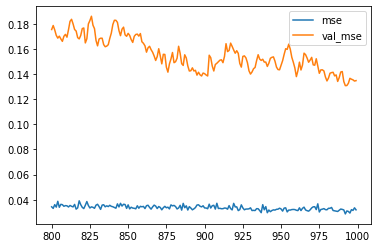

Prediction = 0.513694167137146
Last corr = 0.913523
pred_col_name vfh_vgk_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
0.4527263363202413  minut

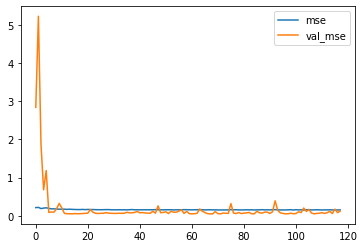

pred_col_name pbj_iwm_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
0.28342680136362713  minutes


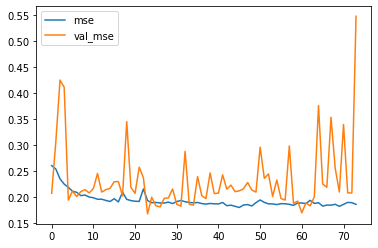

pred_col_name dia_psq_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
0.4595902959505717  minutes


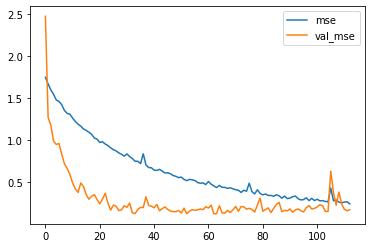

pred_col_name pbj_dia_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
0.3625124454498291  minutes


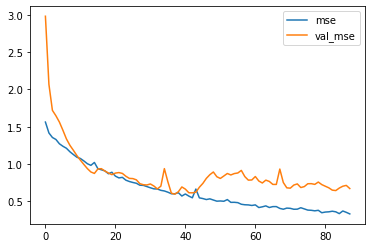

pred_col_name vgk_vnq_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
0.24076577027638754  minutes


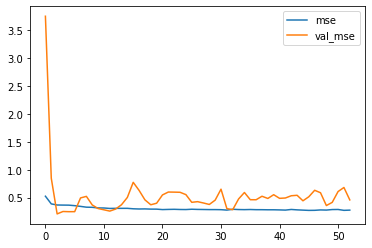

pred_col_name vfh_uso_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
0.4858014146486918  minutes


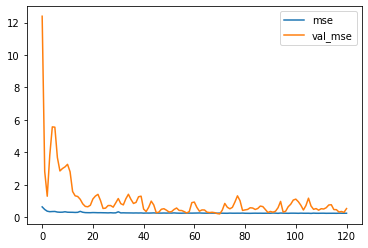

pred_col_name pbj_psq_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
0.31691068410873413  minutes


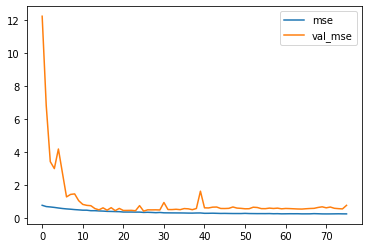

pred_col_name vfh_ibuy_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
0.3081596851348877  minutes


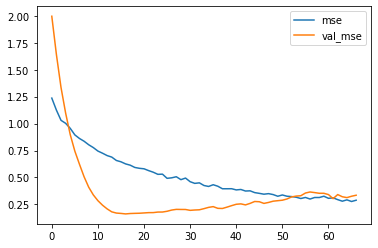

pred_col_name tlt_vti_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
0.3389201680819193  minutes


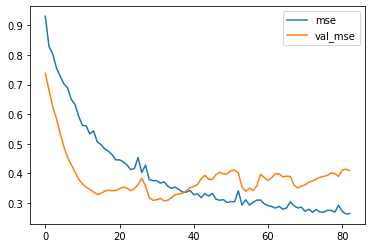

pred_col_name pej_ibuy_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
0.4003894805908203  minutes


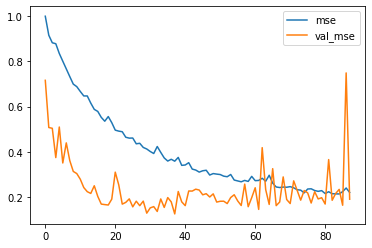

pred_col_name tlt_uso_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
0.2674946665763855  minutes


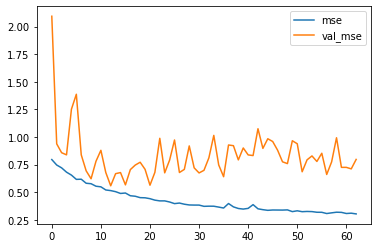

pred_col_name qqq_iwm_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
0.2322880188624064  minutes


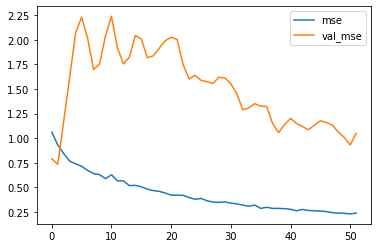

pred_col_name xrt_psq_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
0.3607492844263713  minutes


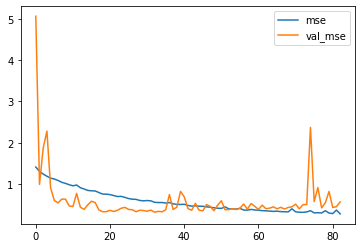

pred_col_name iwm_vnq_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
0.3408214489618937  minutes


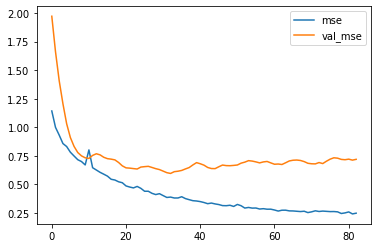

pred_col_name vwo_iwm_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
0.2984030167261759  minutes


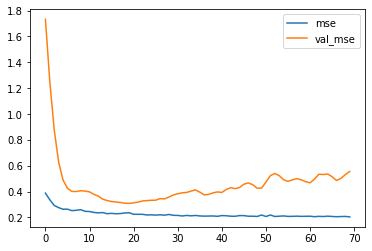

pred_col_name vwo_ibuy_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
0.4797347148259481  minutes
Restoring model weights from the end of the best

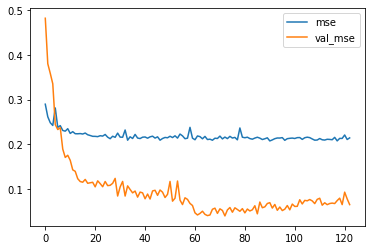

pred_col_name ibuy_vnq_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
0.6172523458798727  minutes


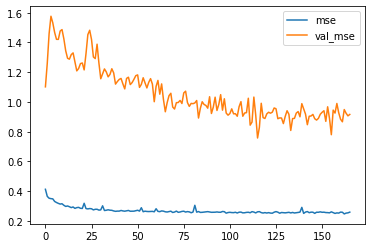

pred_col_name psq_uso_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
0.7246956984202068  minutes


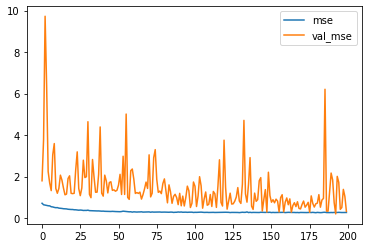

pred_col_name xrt_uso_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
0.32474374771118164  minutes


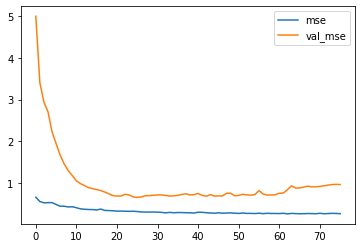

pred_col_name dia_vfh_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
0.48492118120193484  minutes


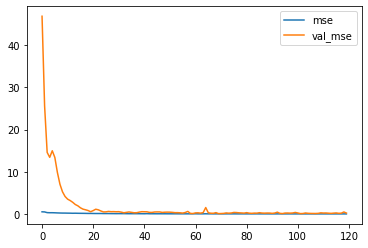

pred_col_name dia_ewz_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
0.7798246502876282  minutes


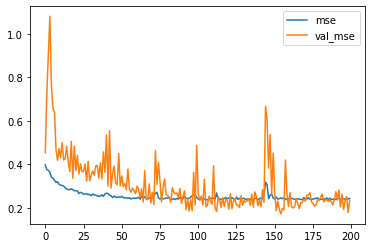

pred_col_name bjk_vgk_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00148: early stopping
0.5754397352536519  minutes


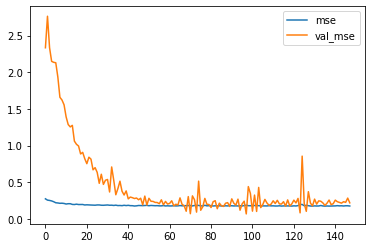

pred_col_name dia_spy_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 887
Total idx checked 887
Restoring model weights from the end of the best epoch.
Epoch 00155: early stopping
0.5772657672564189  minutes


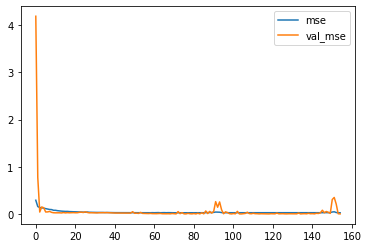

pred_col_name sh_pej_close_corr_rolling_7_days
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935
Pct finished = 0.9029345372460497
Training idx end at 857
Total idx checked 887
Val idx start at 858
Val idx end at 887
X val shape (15, 14, 1173)
n_sequences 886
Training idx start at 0
Pct finished = 0.11286681715575621
Pct finished = 0.22573363431151242
Pct finished = 0.33860045146726864
Pct finished = 0.45146726862302483
Pct finished = 0.5643340857787811
Pct finished = 0.6772009029345373
Pct finished = 0.7900677200902935


KeyboardInterrupt: 

In [33]:
# 6.5 minutes for 10 stocks
final_stock_df = final_stock_df.dropna()
# test 14 day period instead of 30
# no dice
# test smaller network smae LR
# no dice
# test since 2016 data
# no dice
# test smaller learning rate 
# no dice
# test smaller batch size
# nothing
# test batch size  


# so the solution was less validation data

# wal_cwbc is turns out needed less training data

# test a new model for each pair, 200 epochs per . 2 minutes per 200 epochs
# 300 pairs take 10 hours sequentially
# X,y, X_val, y_val, scalers, pca_scalers 
prediction_for_upcoming_week(final_stock_df, pairs_of_stocks, input_verbose=0)

In [185]:
training_data

NameError: name 'training_data' is not defined

In [ ]:
np.isnan(X_val).sum()

In [ ]:
np.isnan(new_X_test).sum()